### ReFRACtor UQ Experiment Analysis

This notebook provides quick summary results from a simulation-based uncertainty quantification experiment, conducted using the [ReFRACtor OCO-2 setup](https://github.com/L2UQ/refractor_uq)

The simulation produces an ouptut file in HDF5 format with the aggregated retrieval results. The analysis consists of two key steps:

* Filtering: Diagnosing if retrievals successfully converged to a solution
    - `RetrievalResults/outcome_flag`: A value of 1 or 2 indicates the optimization reached a solution. A value of 3 indicates convergence was not reached in the allowed number of iterations. A missing value suggests the retrieval was not attempted or a low-level numerical failure occurred during the retrieval.
    - `SpectralParameters/reduced_chi_squared_o2`, `/SpectralParameters/reduced_chi_squared_strong_co2`, `/SpectralParameters/reduced_chi_squared_weak_co2`: These are goodness of fit metrics for each of the three bands. They are normalized, so values around 1 are consistent with successful convergence. If values are several times to an order of magnitude larger, the solution is probably suspect.
* Error assessment: Examining the distribution of retrieved quantities and errors on the subset of successful retrievals
    - `RetrievalResults/retrieved_xco2`, `RetrievalResults/retrieved_state_vector`: Retrieved quantities, which can be compared to their true counterparts: `/StateVector/true_xco2`, `/StateVector/true_state_vector`

In [1]:
import pandas
import numpy
import h5py
import matplotlib
from matplotlib import pyplot
from matplotlib import colors

Read in aggregated retrieval results

In [2]:
fnm = "lnd_nadir_202008_refractor_aggregate_retrieval_D1G0M0.h5" 
f = h5py.File(fnm,'r')
oflg = f['/RetrievalResults/outcome_flag'][:]
nitr = f['/RetrievalResults/number_iterations'][:]
chio2 = f['/SpectralParameters/reduced_chi_squared_o2'][:]
chist = f['/SpectralParameters/reduced_chi_squared_strong_co2'][:]
chiwk = f['/SpectralParameters/reduced_chi_squared_weak_co2'][:]
xco2hat = f['/RetrievalResults/retrieved_xco2'][:]
xco2tr = f['/StateVector/true_xco2'][:]
f.close()

sdsq = numpy.arange(oflg.shape[0])

In [3]:
print(oflg.shape)
print(oflg[0:10])
print(chio2[0:10])

(5000,)
[-99   1   3   1   3 -99 -99   1   1   3]
[-9.9990000e+06  1.0768788e+00  9.8060143e-01  9.6269006e-01
  1.0375115e+00 -9.9990000e+06 -9.9990000e+06  1.1686649e+00
  1.0477123e+00  1.0262780e+00]


Create a data frame and tabulate outcome flag results. Convert XCO2 variables to parts per million

In [5]:
fltfrm = pandas.DataFrame({'SdgSeq':sdsq, 'OFlg':oflg, 'ChiO2':chio2, 'ChiWk':chiwk, 'ChiSt':chist, \
                           'XCO2True': 1.0e6 * xco2tr, 'XCO2Ret': 1.0e6 * xco2hat, 'NIter': nitr})
print(fltfrm[0:5])
print(fltfrm['OFlg'].value_counts())
print(fltfrm['NIter'].value_counts())

   SdgSeq  OFlg         ChiO2         ChiWk         ChiSt    XCO2True  \
0       0   -99 -9.999000e+06 -9.999000e+06 -9.999000e+06  411.308292   
1       1     1  1.076879e+00  9.941166e-01  1.009013e+00  413.589388   
2       2     3  9.806014e-01  9.753079e-01  1.064764e+00  410.027620   
3       3     1  9.626901e-01  9.969173e-01  1.091574e+00  407.801576   
4       4     3  1.037511e+00  1.033304e+00  9.720272e-01  410.831865   

        XCO2Ret  NIter  
0 -9.998999e+12    -99  
1  4.124359e+02      5  
2  4.094287e+02      3  
3  4.067195e+02      3  
4  4.104888e+02      4  
 1     2439
 3     1870
-99     691
Name: OFlg, dtype: int64
 3     1379
 4     1148
-99     691
 5      638
 2      629
 6      310
 7      122
 8       49
 9       16
 10       8
 12       5
 11       5
Name: NIter, dtype: int64


Subset on "good" retrievals

In [6]:
qlfrm = fltfrm.loc[ (fltfrm['OFlg'] == 1) & (fltfrm['ChiO2'] < 10.0) & (fltfrm['ChiWk'] < 10.0) & (fltfrm['ChiSt'] < 10.0)].copy()
print(qlfrm.shape)
qlfrm[100:105]


(2424, 8)


,SdgSeq,OFlg,ChiO2,ChiWk,ChiSt,XCO2True,XCO2Ret,NIter
215,215,1,1.076273,0.996158,1.014418,409.643485,408.799896,3
217,217,1,0.989424,1.067155,1.025127,409.864995,409.180206,7
218,218,1,1.019096,1.059281,0.986392,410.938080,409.779388,4
219,219,1,1.017453,1.012667,1.130291,412.629059,411.924500,3
220,220,1,0.953676,1.027729,1.019866,408.860852,408.427094,3


In [7]:
qlfrm[['ChiO2','ChiWk','ChiSt']].describe()

,ChiO2,ChiWk,ChiSt
count,2424.000000,2424.000000,2424.000000
mean,1.113302,1.169317,1.174163
std,0.351652,0.439366,0.558363
min,0.845321,0.865507,0.835901
25%,1.000260,1.014781,1.000556
50%,1.046413,1.075038,1.048284
75%,1.110481,1.166411,1.119646
max,6.945340,9.536506,9.417591


Summarize XCO2 error

In [8]:
qlfrm['XCO2Err'] = qlfrm['XCO2Ret'] - qlfrm['XCO2True']
qlfrm[['XCO2Err']].describe()

,XCO2Err
count,2424.000000
mean,-0.544265
std,0.518688
min,-4.651592
25%,-0.854695
50%,-0.527963
75%,-0.212380
max,1.230802


In [9]:
qlfrm[['XCO2True']].describe()

,XCO2True
count,2424.000000
mean,410.177114
std,1.956879
min,403.841327
25%,408.823675
50%,410.164411
75%,411.479076
max,416.621625


Text(0.5, 1.0, 'Experiment Retrieval Error')

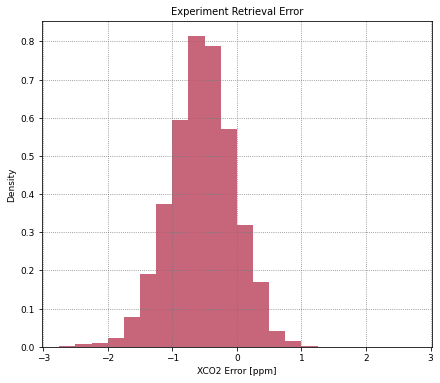

In [10]:
bnsqf = numpy.arange(-2.75,3.0,0.25)
clst = ["#C7657B","#998300","#009958","#0095B3","#A26EC4"]

%matplotlib inline
fig = pyplot.figure(figsize=(7,6))
p1 = pyplot.subplot(1,1,1)
n, bins, patches = pyplot.hist(qlfrm['XCO2Err'],bnsqf,density=True,facecolor=clst[0])
p1.set_xlabel('XCO2 Error [ppm]',size=9)
p1.set_ylabel('Density',size=9)
p1.xaxis.grid(color="#777777",linestyle='dotted')
p1.yaxis.grid(color="#777777",linestyle='dotted')
p1.set_ylim(0,1)
for lb in p1.xaxis.get_ticklabels():
    lb.set_fontsize(9)
for lb in p1.yaxis.get_ticklabels():
    lb.set_fontsize(9)
tstr = 'Experiment Retrieval Error' 
pyplot.title(tstr,size=10)



Save figure as an image

In [12]:
mnerr = numpy.mean(qlfrm['XCO2Err'])
sderr = numpy.std(qlfrm['XCO2Err'])

smrytxt = '''Mean: %.02f
Std Dev: %.02f
''' % (mnerr,sderr)

fig = pyplot.figure(figsize=(7,6),facecolor="white")
p1 = pyplot.subplot(1,1,1)
n, bins, patches = pyplot.hist(qlfrm['XCO2Err'],bnsqf,density=True,facecolor=clst[0])
p1.set_xlabel('XCO2 Error [ppm]',size=12)
p1.set_ylabel('Density',size=12)
p1.xaxis.grid(color="#777777",linestyle='dotted')
p1.yaxis.grid(color="#777777",linestyle='dotted')
p1.set_ylim(0,1)
for lb in p1.xaxis.get_ticklabels():
    lb.set_fontsize(10)
for lb in p1.yaxis.get_ticklabels():
    lb.set_fontsize(10)
tstr = 'Experiment Retrieval Error' 
pyplot.text(1.5,0.8,s=smrytxt,fontsize=12)
pyplot.title(tstr,size=14)
fig.savefig('XCO2_Error_Hist_D1G0M0.png',dpi=200)
pyplot.close()